# Clean RBR and inclino data

In [1]:
import os, sys, pickle, glob
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt

import datetime

import pandas as pd

# cognac data and tools
import cognac.insitu as insi

---

# select a campaign

In [2]:
#campaign = 'microco_leg2.yaml'
#campaign = 'lopstech19_leg1.yaml'
#campaign = 'lopstech19_leg2.yaml'
campaign = 'cognac20.yaml'

cp = insi.utils.campaign(campaign)

---

# RBR 

In [3]:
unit = 'emetteur'
#unit = 'recepteur0'
#unit = 'recepteur1'
#unit = 'recepteur2'

rbr = cp[unit]['instruments']['rbr']
r = insi.rbr.rbr(cp[unit]['path']+'rbr/{}*.txt'.format(rbr), id=rbr)

In [4]:
#r.plot()
r.plot_bk()

Loading BokehJS ...

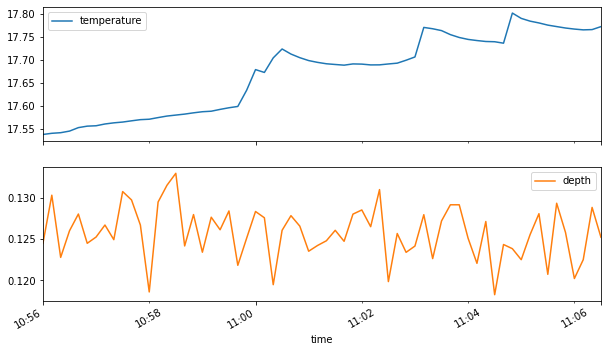

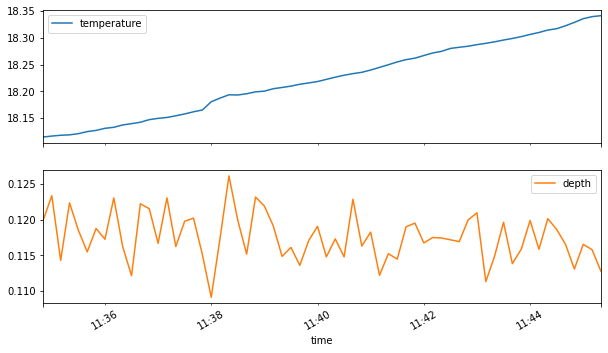

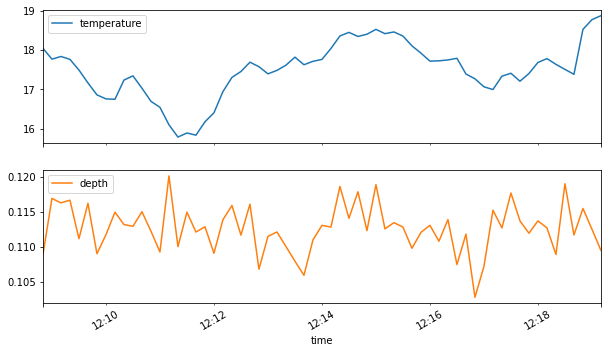

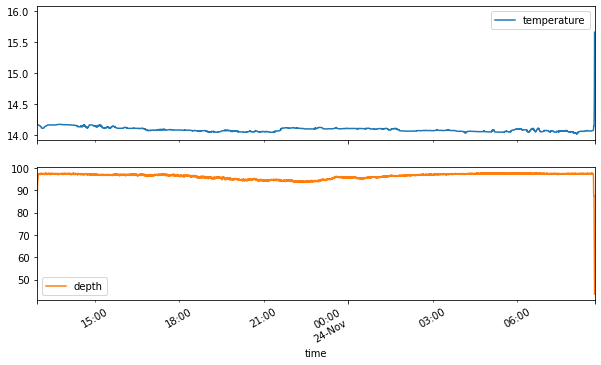

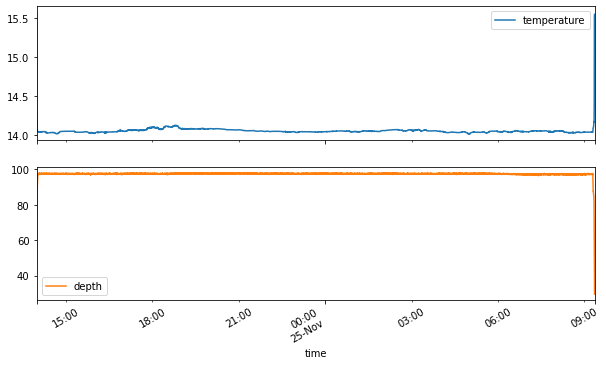

In [5]:
# load and tim data
R={}
for d in cp[unit]:
    R[d.label] = r.trim(d=d)
    R[d.label].plot(figsize=(10,6))

In [18]:
# store data
for label, r in R.items():
    r.to_nc(cp.pathp+unit+'_rbr_'+label+'.nc')

Data store to /Users/aponte/Current_projects/cognac/campagnes/2020_cognac20/data/datap/recepteur2_rbr_j1.nc
Data store to /Users/aponte/Current_projects/cognac/campagnes/2020_cognac20/data/datap/recepteur2_rbr_j2.nc


In [7]:
# reload
r = insi.rbr.rbr(cp.pathp+'emetteur_rbr_j2.nc')

---

# enregistreur: inclino ... to be updated

In [2]:
# data directory and filename
#
#cp = insi.utils.campaign('microco_leg2.yaml')
unit = 'enregistreur'
data_dir = cp[unit]['path']+'inclino/'

dst = ['H0775','H0776']
dep = [18, 8] # found in INI files

files = [data_dir+str(ldep)+ldst+'.DAT' for ldst, ldep in zip(dst, dep)]
_ = [print(f) for f in files]

/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/enregistreur/inclino/18H0775.DAT
/Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/enregistreur/inclino/8H0776.DAT


In [3]:
d = insi.inclino.inclino(files[0], dst[0], dayfirst=True)
print('Start time: ', d['time'][0])
print('End time: ', d['time'][-1])
print('Deployment length: ', d['time'][-1]-d['time'][0])

Start time:  2018-09-09 15:26:00
End time:  2018-09-10 03:32:34
Deployment length:  0 days 12:06:34


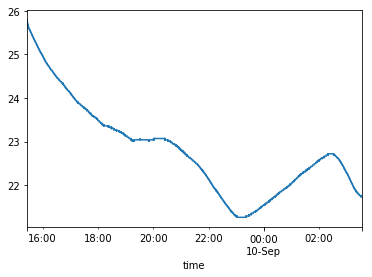

In [4]:
d['temperature'].plot()
# date format is different than for leg1

In [5]:
# Deployments from logs
print(cp[unit]['d1'])

--
Deployment label: d1
Start:
-
Event label: start
Time: 
2018-09-11 06:13:00
Lon:6.198671666666667 = 6.0deg 11.920300000000008
Lat:42.87725833333333 = 42.0deg 52.63549999999981

End:
-
Event label: end
Time: 
2018-09-11 07:31:00
Lon:6.172086666666667 = 6.0deg 10.325200000000017
Lat:42.876378333333335 = 42.0deg 52.5827000000001




The code below is useless: we set a sampling rate of 1Hz which allows deployments of 12h.

We should have used a sampling rate of 0.1Hz

In [6]:
inc={}
for r in cp[unit]:
    print(r.label)
    inc[r.label] = [insi.inclino.inclino(f,d).trim(d=r) for f,d in zip(files,dst)]
    for i in inc[r.label]:
        i.to_pickle(cp.pathp+unit+'_inclino_'+r.label+'_'+i.id+'.p')

[<cognac.insitu.inclino.inclino object at 0x1169ecf28>, <cognac.insitu.inclino.inclino object at 0x11f826fd0>]
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d1_H0775.p
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d1_H0776.p
d1
[<cognac.insitu.inclino.inclino object at 0x123d98fd0>, <cognac.insitu.inclino.inclino object at 0x11fb81fd0>]
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d2_H0775.p
Data store to /Users/aponte/Current_projects/cognac/campagnes_techno/2018_microco/leg2/data/datap/enregistreur_inclino_d2_H0776.p
d2


In [7]:
print(inc)

{'d1': [<cognac.insitu.inclino.inclino object at 0x1169ecf28>, <cognac.insitu.inclino.inclino object at 0x11f826fd0>], 'd2': [<cognac.insitu.inclino.inclino object at 0x123d98fd0>, <cognac.insitu.inclino.inclino object at 0x11fb81fd0>]}


---

In [6]:
%load_ext autoreload

In [7]:
# Reload all modules (except those excluded by %aimport) automatically now.
%autoreload
#from data import *